# Модель определения момента первого прихода взрывной волны

## Содержание

* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Критика](#Критика)

## Постановка задачи

Выделить на сейсмической трассе момент первого приходы взрывной волны

## Датасет
2D сейсмограммы валынтойского участка, 476 сейсмограмм.

Загрузка SPS файлов

In [1]:
import sys
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
from functools import partial
from hmmlearn import hmm

sys.path.append('..')

from batchflow import Dataset, Pipeline, B, V

from geolog import SeismicBatch, FieldIndex, SegyFilesIndex, TraceIndex
from geolog.models import HMModel, make_hmm_data

dfr = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_R_utm.csv')
dfs = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_S_utm.csv')
dfx = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_X37.csv')

Индексация SPS файлов

In [2]:
field_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx)
field_index._idf.head()

,sline,sid,rline,rid,TraceNumber,point_index,sht_depth,uphole,x_s,y_s,z_s,x_r,y_r,z_r,offset
,,,,,,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,
481,S37,1011,R37,101,1,1,18.0,8.0,338283.90,7026994.0,70.0,338283.9,7026994.0,70.0,0.000000
480,S37,1031,R37,101,1,1,18.0,8.0,338288.62,7027043.5,69.9,338283.9,7026994.0,70.0,24.862263
479,S37,1051,R37,101,1,1,18.0,9.0,338293.30,7027093.5,69.8,338283.9,7026994.0,70.0,49.971517
478,S37,1071,R37,101,1,1,18.0,9.0,338298.00,7027143.0,69.7,338283.9,7026994.0,70.0,74.832830
477,S37,1091,R37,101,1,1,18.0,8.0,338302.70,7027193.0,69.6,338283.9,7026994.0,70.0,99.943034


Привязка segy файлов

In [3]:
segy_index = SegyFilesIndex(name='raw', path='/notebooks/egor/2D_Valyton/prof_37/segy/*.sgy', drop_duplicates=True)
field_index = field_index.merge(segy_index)
field_index._idf.head()

,sline,sid,rline,rid,TraceNumber,point_index,sht_depth,uphole,x_s,y_s,z_s,x_r,y_r,z_r,offset,file_id,TRACE_SEQUENCE_FILE
,,,,,,,,,,,,,,,,raw,raw
FieldRecord,,,,,,,,,,,,,,,,,
481,S37,1011,R37,101,1,1,18.0,8.0,338283.90,7026994.0,70.0,338283.9,7026994.0,70.0,0.000000,/notebooks/egor/2D_Valyton/prof_37/segy/000004...,3
480,S37,1031,R37,101,1,1,18.0,8.0,338288.62,7027043.5,69.9,338283.9,7026994.0,70.0,24.862263,/notebooks/egor/2D_Valyton/prof_37/segy/000004...,3
479,S37,1051,R37,101,1,1,18.0,9.0,338293.30,7027093.5,69.8,338283.9,7026994.0,70.0,49.971517,/notebooks/egor/2D_Valyton/prof_37/segy/000004...,3
478,S37,1071,R37,101,1,1,18.0,9.0,338298.00,7027143.0,69.7,338283.9,7026994.0,70.0,74.832830,/notebooks/egor/2D_Valyton/prof_37/segy/000004...,3
477,S37,1091,R37,101,1,1,18.0,8.0,338302.70,7027193.0,69.6,338283.9,7026994.0,70.0,99.943034,/notebooks/egor/2D_Valyton/prof_37/segy/000004...,3


Создание обучающего датасета (1 первая сейсмограмма)

In [6]:
train_set = Dataset(field_index.create_subset(field_index.indices[:1]), SeismicBatch)

Загрузка батча из сейсмограмм

In [7]:
batch = train_set.next_batch(1).load(components='raw').to_2d(components='raw')

Просмотр cейсмограммы

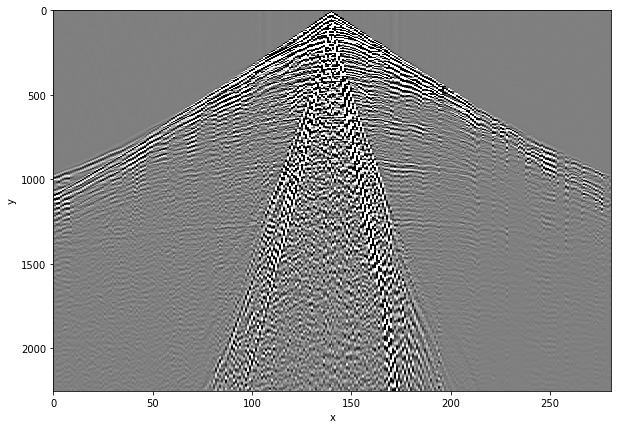

In [8]:
cv = 3
batch.show_slice(batch.indices[0], component='raw', figsize=(10, 7), vmin=-cv, vmax=cv, cmap='gray')

## Архитектура

Используется модель скрытой марковской цепи с двумя состояниями. Предполагается, что один тип состояний отвечает полезному сигналу, другой - внешним шумам. Первый момент перехода из состояния "шум" в состояние "полезный сигнал" должен отвечать моменту первого прихода взрывной волны. Предполагается, что в начальный момент времени состояние "шум" должно быть наиболее вероятно.

Конфигурация модели

In [24]:
config_train = {
    'build': True,
    'estimator': hmm.GaussianHMM(n_components=2, n_iter=20, covariance_type="full")
}

## Обучение

Пайплайн обучения модели

In [27]:
batch_size = 1
cv = 3

train_pipeline = (Pipeline()
                 .init_model("dynamic", HMModel, "HMM", config=config_train)
                 .load(components='raw')
                 .to_2d(components='raw')
                 .apply_transform(np.clip, a_min=-cv, a_max=cv, src="raw", dst="raw")
                 .gradient(src="raw", dst="grad")
                 .cwt(src="grad", dst="wavelet", scales=[4], wavelet="mexh")
                 .train_model("HMM", make_data=partial(make_hmm_data, components='wavelet'))
                 .run(batch_size=batch_size, n_epochs=1, shuffle=False, drop_last=False, lazy=True))

Запуск обучения

In [28]:
(train_set >> train_pipeline).run()

Сохранение обученной модели

In [29]:
train_pipeline.save_model("HMM", path="_picks_model.dill")

## Инференс

Конфигурация модели для инференса

In [30]:
hmmodel_path = "_picks_model.dill"

config_predict = {
    'build': False,
    'load': {'path': hmmodel_path}
}

with open(hmmodel_path, "rb") as file:
    hmmodel = dill.load(file)
signal_label = np.argmin(hmmodel.startprob_)

def get_first_arrival(arr, signal_label):
    indices = np.where(arr == signal_label)[0]
    return indices[0] if len(indices) else -1

Пайплайн инференса

In [31]:
batch_size = 100
cv = 3

test_pipeline = (Pipeline()
                 .init_model("static", HMModel, "HMM", config=config_predict)
                 .load(components='raw')
                 .to_2d(components='raw')
                 .apply_transform(np.clip, a_min=-cv, a_max=cv, src="raw", dst="raw")
                 .gradient(src="raw", dst="grad")
                 .cwt(src="grad", dst="wavelet", scales=[4], wavelet="mexh")
                 .predict_model("HMM", make_data=partial(make_hmm_data, components='wavelet'),
                                save_to=B("hmm_predictions"), mode='w')
                 .apply_to_each_channel(get_first_arrival, src="hmm_predictions",
                                        dst="hmm_predictions", signal_label=signal_label)
                 .run(batch_size=batch_size, shuffle=False, drop_last=False, n_epochs=1, lazy=True))

Связывание тестового датасета с пайплайном

In [41]:
test_set = Dataset(field_index.create_subset(field_index.indices[1:]), SeismicBatch)
test_pipeline = (test_set >> test_pipeline)

Прогон набора батчей через пайплайн

In [42]:
batch = test_pipeline.next_batch(100)

Просмотр сейсмограмм и полученных значений для первых моментов

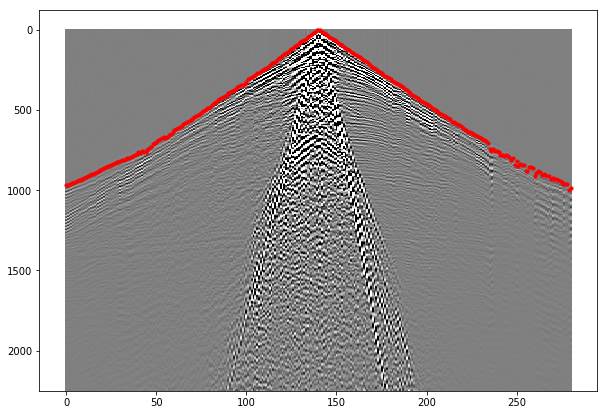

In [53]:
i = 8
picks = batch.hmm_predictions[i]

plt.figure(figsize=(10, 7))
plt.imshow(batch.raw[i].T, cmap='gray')
plt.scatter(np.arange(len(picks)), picks, s=10, c='r')
plt.axes().set_aspect('auto')
plt.show()

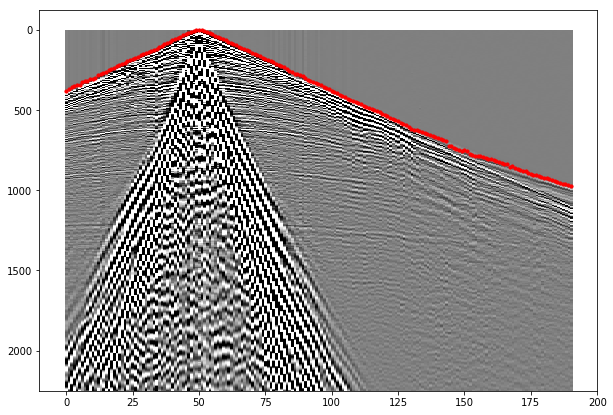

In [52]:
i = 44
picks = batch.hmm_predictions[i]

plt.figure(figsize=(10, 7))
plt.imshow(batch.raw[i].T, cmap='gray')
plt.scatter(np.arange(len(picks)), picks, s=10, c='r')
plt.axes().set_aspect('auto')
plt.show()

## Критика

На отдельных сейсограммах можно заметить выбросы с определении моментов первых вступлений. Отчасти они связаны с шумами на сейсмограммах.

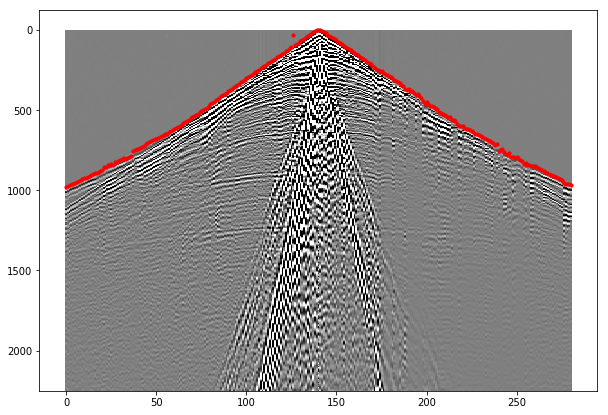

In [50]:
i = 94
picks = batch.hmm_predictions[i]

plt.figure(figsize=(10, 7))
plt.imshow(batch.raw[i].T, cmap='gray')
plt.scatter(np.arange(len(picks)), picks, s=10, c='r')
plt.axes().set_aspect('auto')
plt.show()

Для повышения устойчивости следует предварительно провести фильтрацию шумов и развить модель в сторону учета соседних трасс.